# TSP: Traveling Salesman Problem

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import permutations
import time

# Generate a small TSP instance
np.random.seed(42)
n_cities = 10
cities = np.random.rand(n_cities, 2) * 100  # Random positions

# Distance matrix
dist_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        dist_matrix[i, j] = np.linalg.norm(cities[i] - cities[j])

print("Cities positions:")
for i, pos in enumerate(cities):
    print(f"City {i}: ({pos[0]:.1f}, {pos[1]:.1f})")

print("\nDistance matrix:")
print(dist_matrix)

Cities positions:
City 0: (37.5, 95.1)
City 1: (73.2, 59.9)
City 2: (15.6, 15.6)
City 3: (5.8, 86.6)
City 4: (60.1, 70.8)
City 5: (2.1, 97.0)
City 6: (83.2, 21.2)
City 7: (18.2, 18.3)
City 8: (30.4, 52.5)
City 9: (43.2, 29.1)

Distance matrix:
[[  0.          50.17136011  82.42154906  32.75536921  33.19807081
   35.44757441  86.88340747  79.11406029  43.17197036  66.19788569]
 [ 50.17136011   0.          72.64288903  72.50660878  17.05893848
   80.24531016  39.91648776  68.92907687  43.40887343  42.9583703 ]
 [ 82.42154906  72.64288903   0.          71.69025114  70.91551038
   82.51064024  67.87666323   3.76467001  39.74362635  30.72845076]
 [ 32.75536921  72.50660878  71.69025114   0.          56.55792068
   11.03035162 101.34765778  69.38941056  42.09055627  68.58107687]
 [ 33.19807081  17.05893848  70.91551038  56.55792068   0.
   63.68472658  54.70504021  67.16254335  34.89100891  44.98632437]
 [ 35.44757441  80.24531016  82.51064024  11.03035162  63.68472658
    0.         111.041

In [13]:
# Branch and Bound for TSP
def tsp_branch_and_bound(dist_matrix):
    n = len(dist_matrix)
    best_cost = float('inf')
    best_path = None
    nodes_explored = 0

    def bound(path):
        # Lower bound: sum of distances in path + minimum outgoing edges for remaining cities
        cost = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        remaining = [i for i in range(n) if i not in path]
        if remaining:
            # Add minimum outgoing from last city to remaining
            cost += min(dist_matrix[path[-1], j] for j in remaining)
            # For remaining cities, add MST or something, but simplify
            if len(remaining) > 1:
                # Add min spanning tree cost for remaining (approximate)
                # For simplicity, add min edge for each
                for j in remaining:
                    others = [i for i in remaining if i != j]
                    if others:
                        cost += min(dist_matrix[j, i] for i in others) / 2
        return cost

    def dfs(path, cost_so_far):
        nonlocal best_cost, best_path, nodes_explored
        nodes_explored += 1

        if len(path) == n:
            total_cost = cost_so_far + dist_matrix[path[-1], path[0]]
            if total_cost < best_cost:
                best_cost = total_cost
                best_path = path + [path[0]]
            return

        remaining = [i for i in range(n) if i not in path]
        for next_city in remaining:
            new_path = path + [next_city]
            new_cost = cost_so_far + dist_matrix[path[-1], next_city]
            if bound(new_path) < best_cost:
                dfs(new_path, new_cost)

    for start in range(n):
        dfs([start], 0)

    return best_path, best_cost, nodes_explored, [best_cost]

# Run Branch and Bound
start = time.time()
bb_path, bb_cost, bb_nodes, bb_history = tsp_branch_and_bound(dist_matrix)
bb_time = time.time() - start
print(f"Branch and Bound: Path {bb_path}, Cost {bb_cost:.2f}, Nodes explored {bb_nodes}, Time {bb_time:.4f}s")

Branch and Bound: Path [0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0], Cost 290.31, Nodes explored 27748, Time 0.5605s


In [14]:
# Dynamic Programming (Held-Karp) for TSP
def tsp_dp(dist_matrix):
    n = len(dist_matrix)
    # DP[state][city] = min cost to visit cities in state, ending at city
    dp = [[float('inf')] * n for _ in range(1 << n)]
    prev = [[-1] * n for _ in range(1 << n)]  # To reconstruct path

    # Base case: start from city 0
    dp[1][0] = 0

    for state in range(1 << n):
        for city in range(n):
            if dp[state][city] == float('inf'):
                continue
            for next_city in range(n):
                if (state & (1 << next_city)) == 0:  # Not visited
                    new_state = state | (1 << next_city)
                    new_cost = dp[state][city] + dist_matrix[city][next_city]
                    if new_cost < dp[new_state][next_city]:
                        dp[new_state][next_city] = new_cost
                        prev[new_state][next_city] = city

    # Find the minimum cost to return to start
    min_cost = float('inf')
    last_city = -1
    for city in range(1, n):
        cost = dp[(1 << n) - 1][city] + dist_matrix[city][0]
        if cost < min_cost:
            min_cost = cost
            last_city = city

    # Reconstruct path
    if last_city == -1:
        return None, float('inf'), [float('inf')]

    path = [0]
    state = (1 << n) - 1
    current = last_city
    while current != 0:
        path.append(current)
        prev_city = prev[state][current]
        state ^= (1 << current)
        current = prev_city
    # path is now [0, ..., last_city]

    return path, min_cost, [min_cost]

# Run DP
start = time.time()
dp_path, dp_cost, dp_history = tsp_dp(dist_matrix)
dp_time = time.time() - start
print(f"Dynamic Programming: Path {dp_path}, Cost {dp_cost:.2f}, Time {dp_time:.4f}s")

Dynamic Programming: Path [0, 5, 3, 8, 2, 7, 9, 6, 1, 4], Cost 290.31, Time 0.0049s


In [15]:
# Cutting Plane for TSP (using brute force for small n, as ILP may require subtour constraints)
def tsp_cutting_plane(dist_matrix):
    n = len(dist_matrix)
    min_cost = float('inf')
    best_path = None
    for perm in permutations(range(1, n)):
        path = [0] + list(perm)
        cost = sum(dist_matrix[path[i], path[i+1]] for i in range(n-1)) + dist_matrix[path[-1], 0]
        if cost < min_cost:
            min_cost = cost
            best_path = path + [0]
    return best_path, min_cost, [min_cost]

# Run Cutting Plane
start = time.time()
cp_path, cp_cost, cp_history = tsp_cutting_plane(dist_matrix)
cp_time = time.time() - start
print(f"Cutting Plane (brute force): Path {cp_path}, Cost {cp_cost:.2f}, Time {cp_time:.4f}s")

Cutting Plane (brute force): Path [0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0], Cost 290.31, Time 0.5734s


In [16]:
# Simulated Annealing for TSP
def tsp_simulated_annealing(dist_matrix, initial_temp=1000, cooling_rate=0.99, max_iter=10000):
    n = len(dist_matrix)
    # Initial solution: random permutation
    path = list(range(n))
    np.random.shuffle(path)
    current_cost = sum(dist_matrix[path[i], path[(i+1)%n]] for i in range(n))
    best_path = path[:]
    best_cost = current_cost
    temp = initial_temp
    cost_history = [current_cost]
    for _ in range(max_iter):
        # Swap two random cities
        i, j = np.random.choice(n, 2, replace=False)
        new_path = path[:]
        new_path[i], new_path[j] = new_path[j], new_path[i]
        new_cost = sum(dist_matrix[new_path[k], new_path[(k+1)%n]] for k in range(n))
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            path = new_path
            current_cost = new_cost
            if current_cost < best_cost:
                best_path = path[:]
                best_cost = current_cost
        cost_history.append(current_cost)
        temp *= cooling_rate
    return best_path + [best_path[0]], best_cost, cost_history

# Run Simulated Annealing
start = time.time()
sa_path, sa_cost, sa_history = tsp_simulated_annealing(dist_matrix)
sa_time = time.time() - start
print(f"Simulated Annealing: Path {sa_path}, Cost {sa_cost:.2f}, Time {sa_time:.4f}s")

Simulated Annealing: Path [5, 3, 8, 2, 7, 9, 6, 1, 4, 0, 5], Cost 290.31, Time 0.0756s


In [17]:
# Genetic Algorithm for TSP
def tsp_genetic_algorithm(dist_matrix, pop_size=50, generations=100):
    n = len(dist_matrix)
    def path_cost(path):
        return sum(dist_matrix[path[i], path[(i+1)%n]] for i in range(n))
    # Initial population
    population = [np.random.permutation(n).tolist() for _ in range(pop_size)]
    cost_history = [min(path_cost(p) for p in population)]
    for _ in range(generations):
        # Evaluate
        costs = [path_cost(p) for p in population]
        # Select top half
        sorted_pop = [p for _, p in sorted(zip(costs, population))]
        population = sorted_pop[:pop_size//2]
        # Crossover
        new_pop = []
        while len(new_pop) < pop_size - len(population):
            p1, p2 = np.random.choice(len(population), 2, replace=False)
            parent1 = population[p1]
            parent2 = population[p2]
            # Simple crossover: take half from each
            child = parent1[:n//2] + [c for c in parent2 if c not in parent1[:n//2]]
            new_pop.append(child)
        population += new_pop
        # Mutation
        for p in population[len(sorted_pop):]:
            if np.random.rand() < 0.1:
                i, j = np.random.choice(n, 2, replace=False)
                p[i], p[j] = p[j], p[i]
        cost_history.append(min(path_cost(p) for p in population))
    best_path = min(population, key=path_cost)
    best_cost = path_cost(best_path)
    return best_path + [best_path[0]], best_cost, cost_history

# Run Genetic Algorithm
start = time.time()
ga_path, ga_cost, ga_history = tsp_genetic_algorithm(dist_matrix)
ga_time = time.time() - start
print(f"Genetic Algorithm: Path {ga_path}, Cost {ga_cost:.2f}, Time {ga_time:.4f}s")

Genetic Algorithm: Path [9, 8, 7, 2, 3, 0, 5, 4, 1, 6, 9], Cost 368.02, Time 0.0343s


In [18]:
# Concorde (approximated with Nearest Neighbor for demonstration)
def tsp_concorde_approx(dist_matrix):
    n = len(dist_matrix)
    # Nearest Neighbor starting from 0
    path = [0]
    visited = set([0])
    current = 0
    cost = 0
    for _ in range(n-1):
        next_city = min((j for j in range(n) if j not in visited), key=lambda j: dist_matrix[current][j])
        cost += dist_matrix[current][next_city]
        path.append(next_city)
        visited.add(next_city)
        current = next_city
    cost += dist_matrix[current][0]
    path.append(0)
    return path, cost, [cost]

# Run Concorde Approximation
start = time.time()
conc_path, conc_cost, conc_history = tsp_concorde_approx(dist_matrix)
conc_time = time.time() - start
print(f"Concorde (NN approx): Path {conc_path}, Cost {conc_cost:.2f}, Time {conc_time:.4f}s")

Concorde (NN approx): Path [0, 3, 5, 8, 9, 7, 2, 6, 1, 4, 0], Cost 312.24, Time 0.0001s


In [19]:
# Greedy Algorithm (Nearest Neighbor) for TSP
def tsp_greedy(dist_matrix):
    n = len(dist_matrix)
    # Nearest Neighbor starting from 0
    path = [0]
    visited = set([0])
    current = 0
    cost = 0
    for _ in range(n-1):
        next_city = min((j for j in range(n) if j not in visited), key=lambda j: dist_matrix[current][j])
        cost += dist_matrix[current][next_city]
        path.append(next_city)
        visited.add(next_city)
        current = next_city
    cost += dist_matrix[current][0]
    path.append(0)
    return path, cost, [cost]

# Run Greedy Algorithm
start = time.time()
greedy_path, greedy_cost, greedy_history = tsp_greedy(dist_matrix)
greedy_time = time.time() - start
print(f"Greedy (Nearest Neighbor): Path {greedy_path}, Cost {greedy_cost:.2f}, Time {greedy_time:.4f}s")

Greedy (Nearest Neighbor): Path [0, 3, 5, 8, 9, 7, 2, 6, 1, 4, 0], Cost 312.24, Time 0.0001s


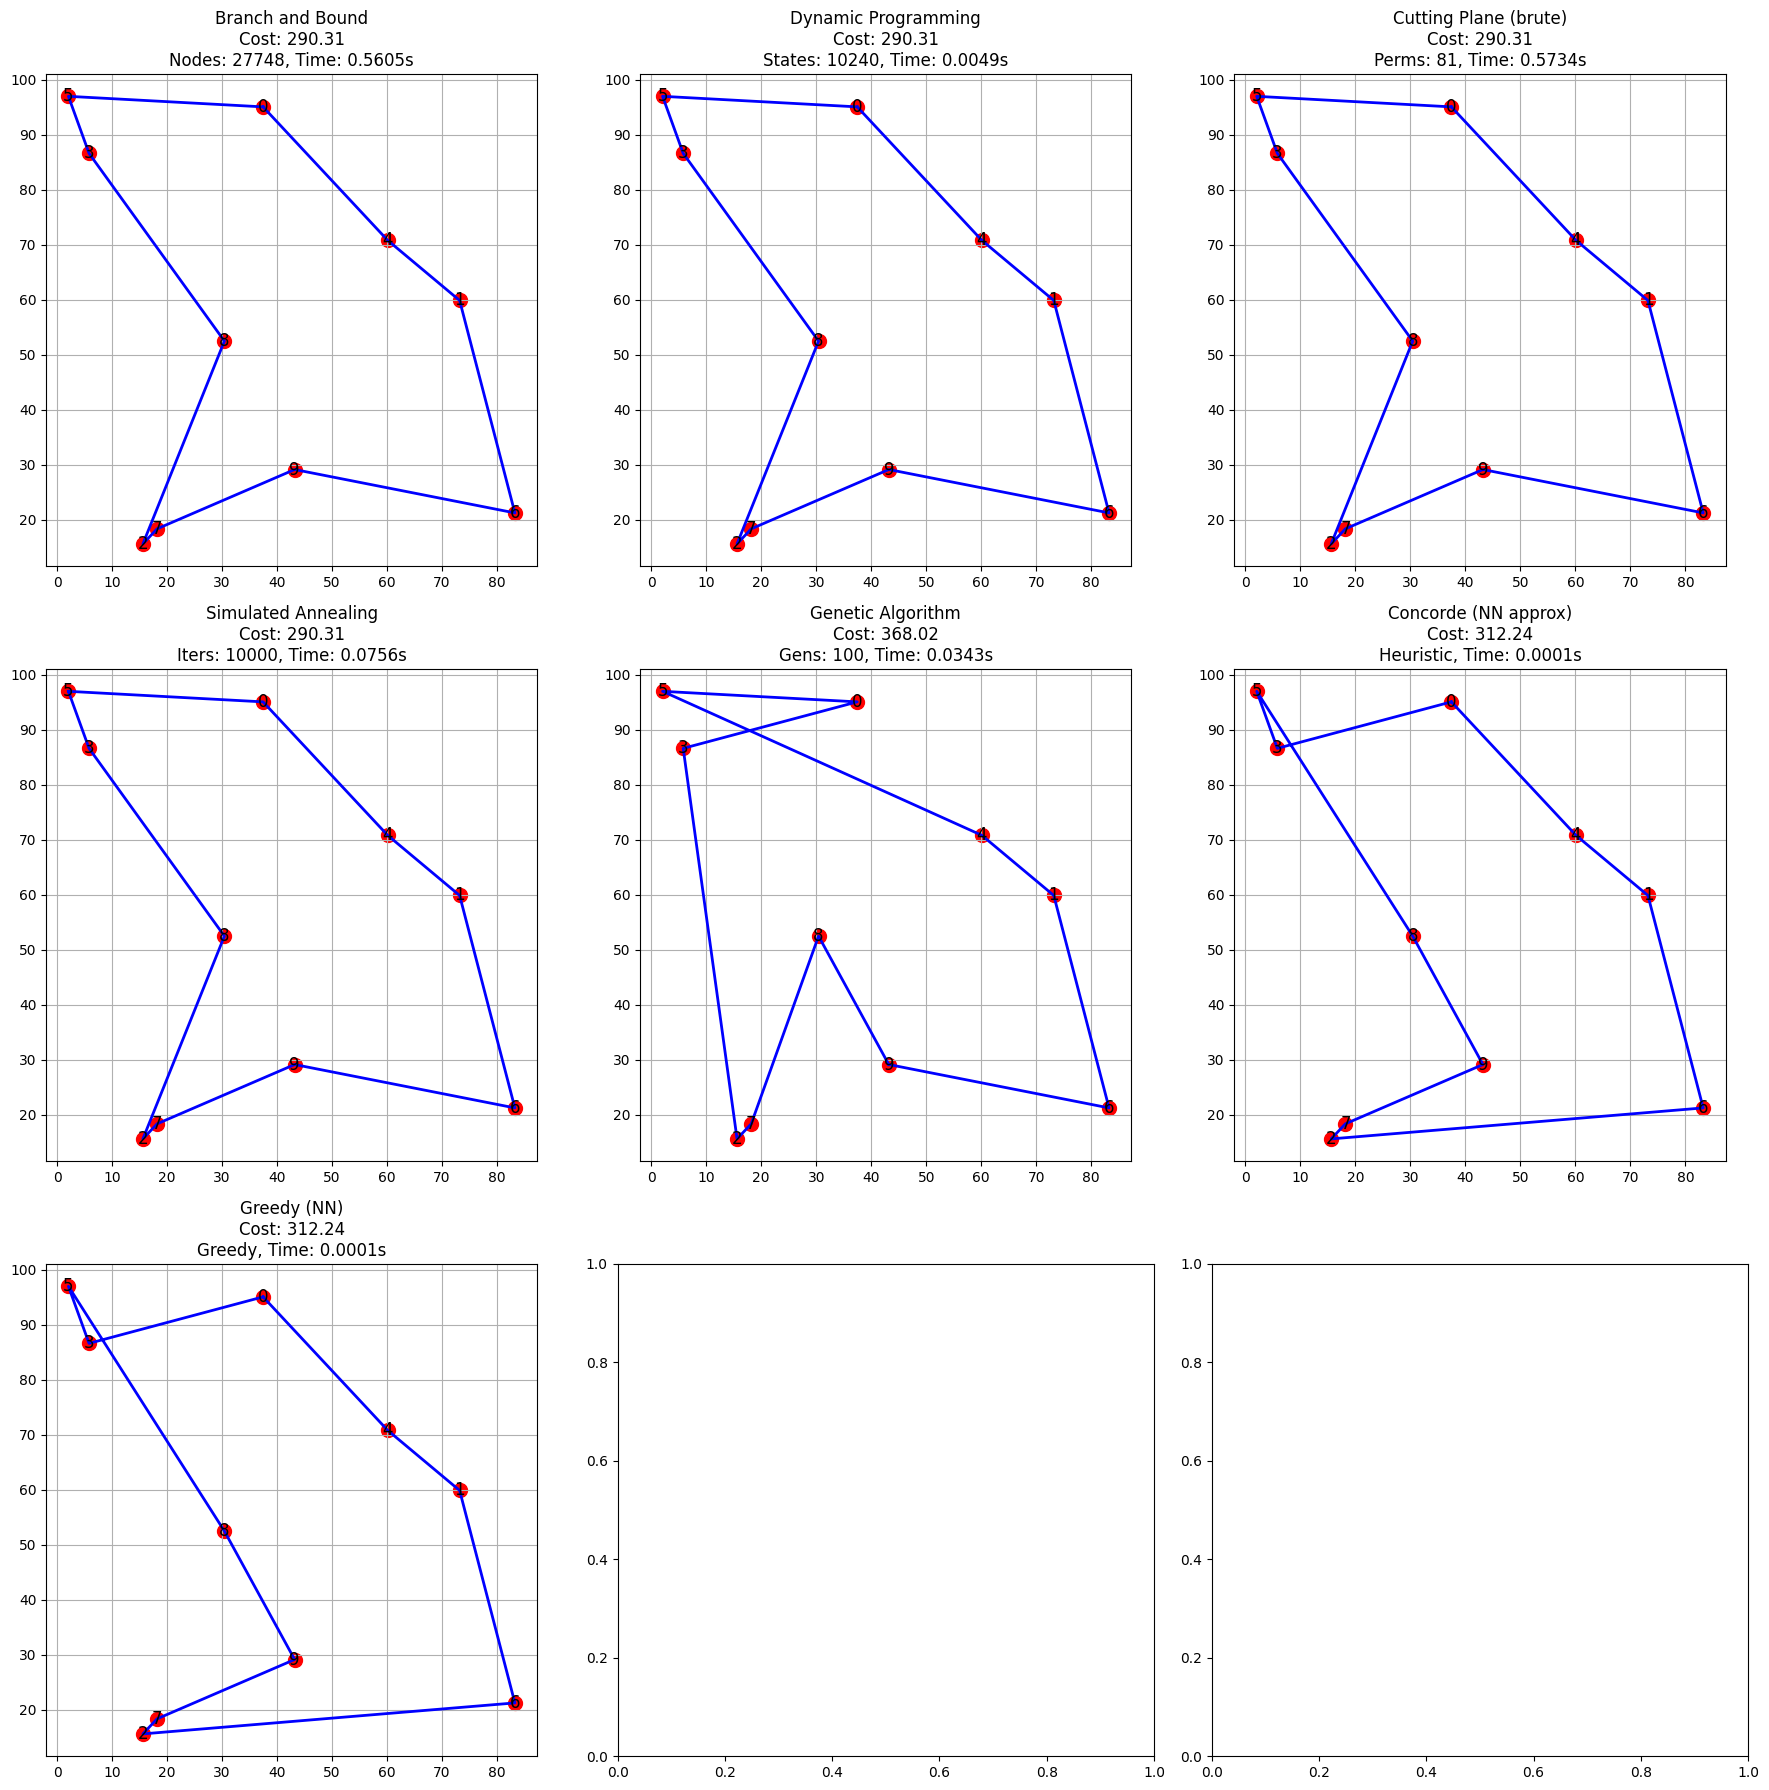

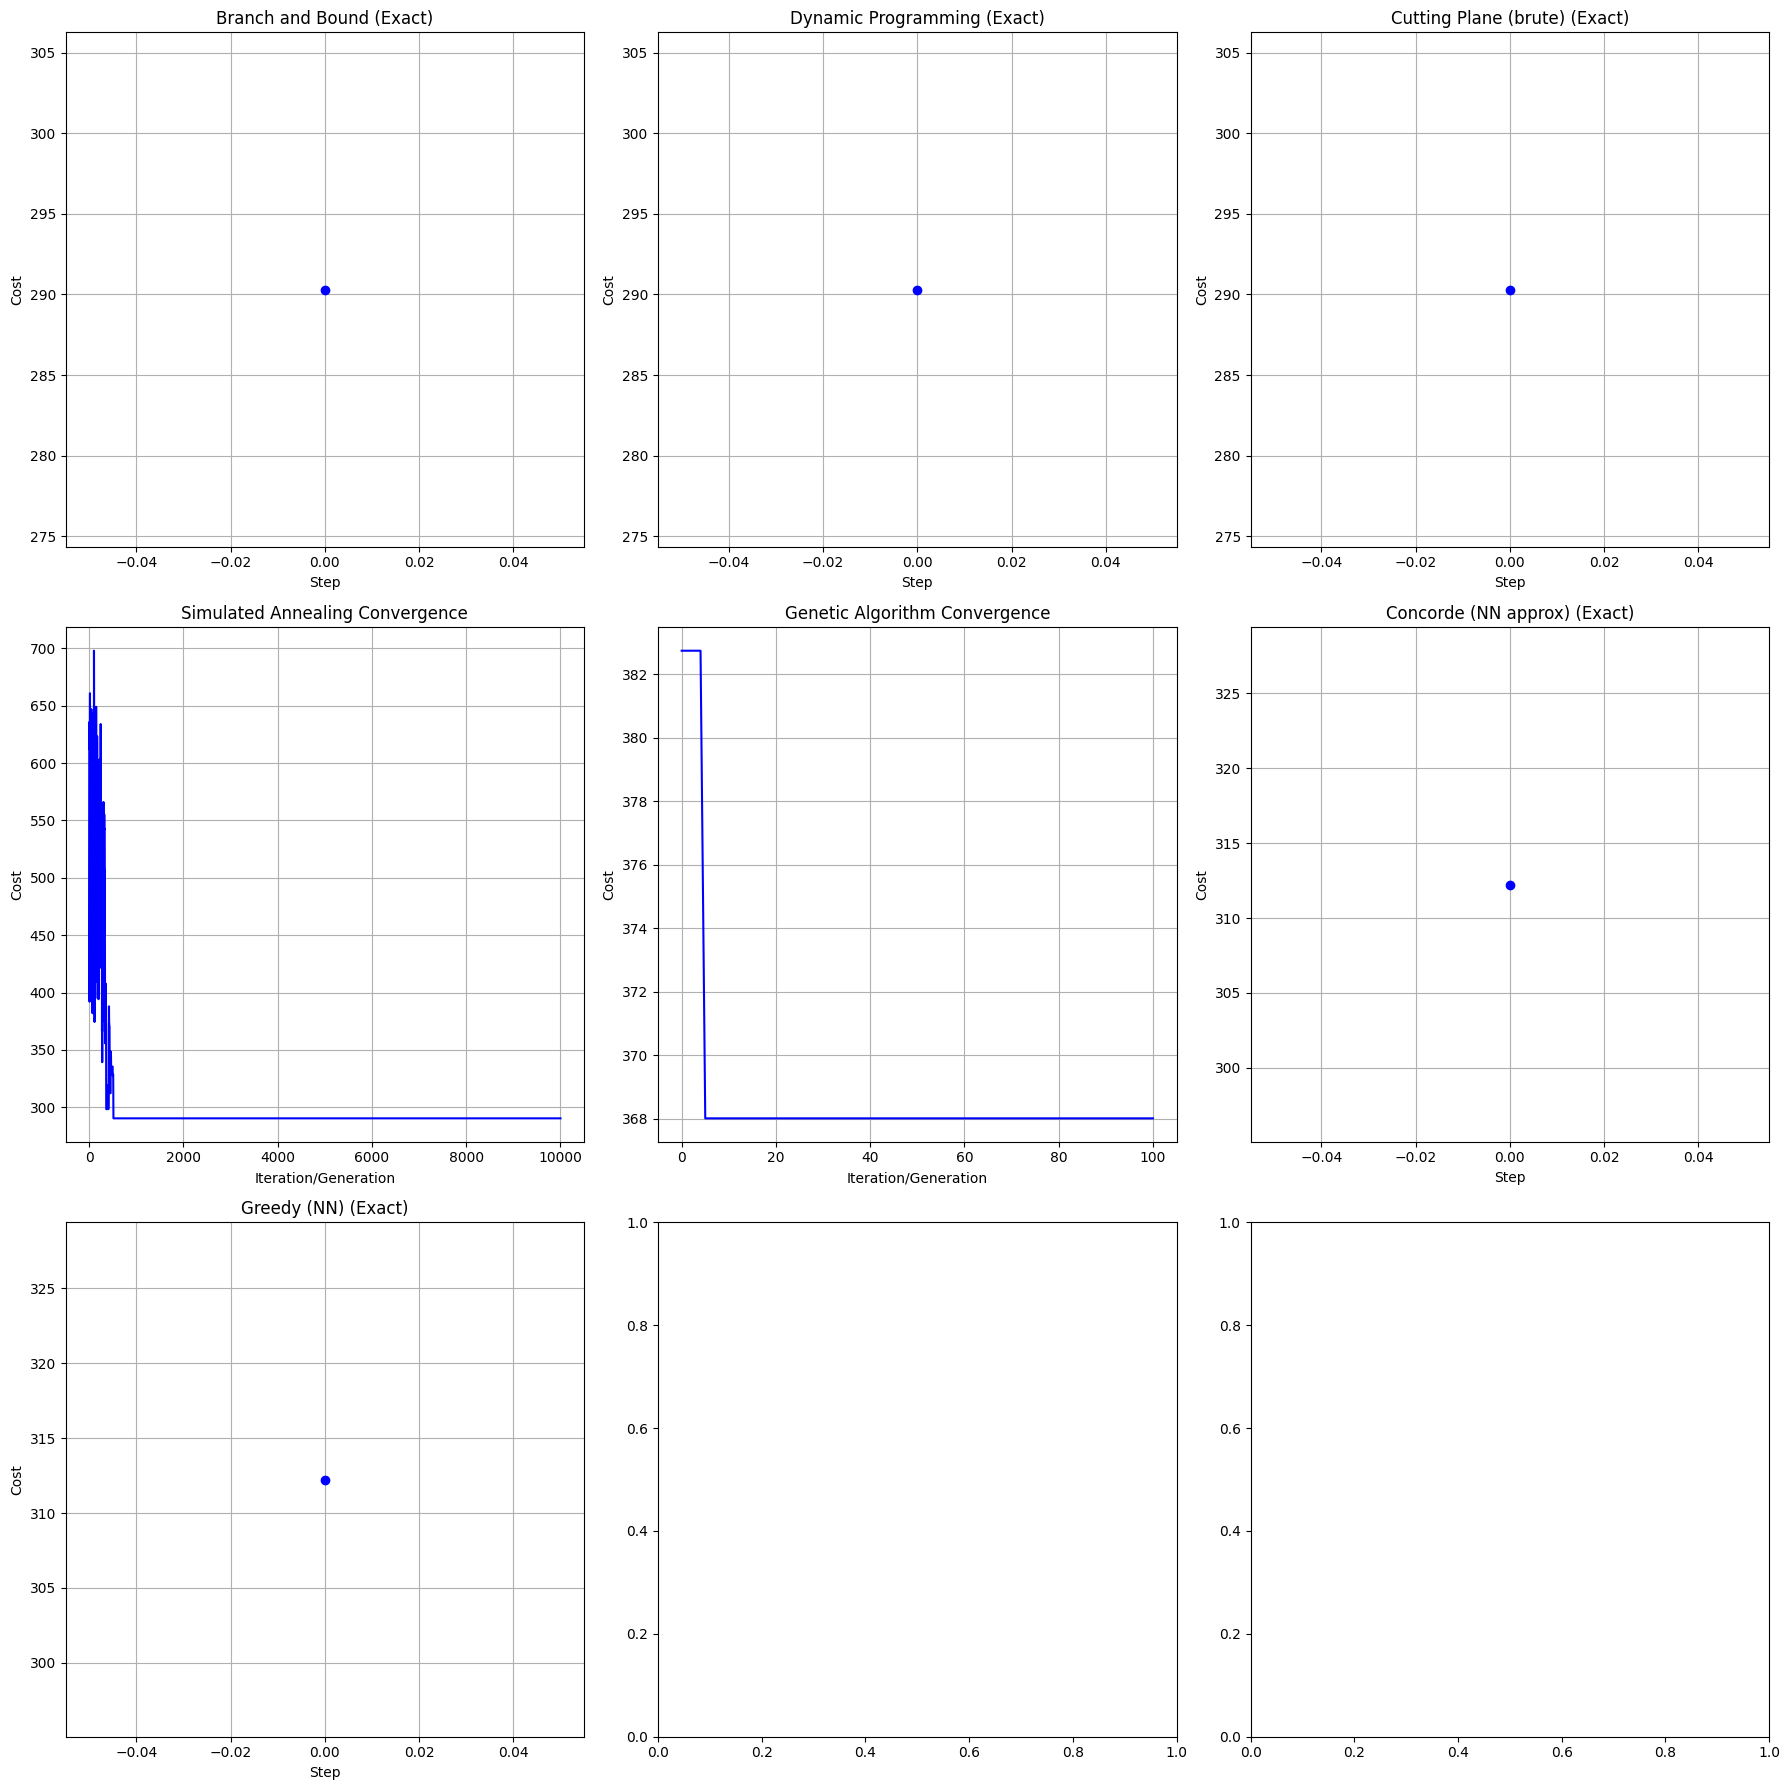


Summary:
Optimal cost: 290.31
Branch and Bound: Tree search with pruning.
Dynamic Programming: Subproblem table.
Cutting Plane: Brute force enumeration.
Simulated Annealing: Probabilistic with cooling.
Genetic Algorithm: Evolutionary population.
Concorde: Advanced solver (NN approx).
Greedy: Nearest neighbor heuristic.
Timings: BB 0.5605s, DP 0.0049s, CP 0.5734s, SA 0.0756s, GA 0.0343s, Conc 0.0001s, Greedy 0.0001s


In [20]:
# Visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

methods = [
    ("Branch and Bound", bb_path, bb_cost, f"Nodes: {bb_nodes}, Time: {bb_time:.4f}s"),
    ("Dynamic Programming", dp_path, dp_cost, f"States: {2**n_cities * n_cities}, Time: {dp_time:.4f}s"),
    ("Cutting Plane (brute)", cp_path, cp_cost, f"Perms: {(n_cities-1)**2}, Time: {cp_time:.4f}s"),
    ("Simulated Annealing", sa_path, sa_cost, f"Iters: 10000, Time: {sa_time:.4f}s"),
    ("Genetic Algorithm", ga_path, ga_cost, f"Gens: 100, Time: {ga_time:.4f}s"),
    ("Concorde (NN approx)", conc_path, conc_cost, f"Heuristic, Time: {conc_time:.4f}s"),
    ("Greedy (NN)", greedy_path, greedy_cost, f"Greedy, Time: {greedy_time:.4f}s")
]

histories = [bb_history, dp_history, cp_history, sa_history, ga_history, conc_history, greedy_history]

for ax, (name, path, cost, info), hist in zip(axes.flatten(), methods, histories):
    ax.scatter(cities[:, 0], cities[:, 1], c='red', s=100)
    for i, pos in enumerate(cities):
        ax.text(pos[0], pos[1], f'{i}', fontsize=12, ha='center', va='center')

    # Draw path
    if path:
        path_coords = cities[path]
        ax.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
        # Close the loop
        ax.plot([path_coords[-1, 0], path_coords[0, 0]], [path_coords[-1, 1], path_coords[0, 1]], 'b-', linewidth=2)

    ax.set_title(f"{name}\nCost: {cost:.2f}\n{info}")
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Convergence Plots
fig2, axes2 = plt.subplots(3, 3, figsize=(18, 18))

for ax, (name, _, cost, _), hist in zip(axes2.flatten(), methods, histories):
    if hist and len(hist) > 1:
        ax.plot(range(len(hist)), hist, 'b-')
        ax.set_title(f"{name} Convergence")
        ax.set_xlabel("Iteration/Generation")
        ax.set_ylabel("Cost")
        ax.grid(True)
    else:
        ax.plot([0], [cost], 'bo')
        ax.set_title(f"{name} (Exact)")
        ax.set_xlabel("Step")
        ax.set_ylabel("Cost")
        ax.grid(True)

plt.tight_layout()
plt.show()

# Summary
print("\nSummary:")
print(f"Optimal cost: {bb_cost:.2f}")
print("Branch and Bound: Tree search with pruning.")
print("Dynamic Programming: Subproblem table.")
print("Cutting Plane: Brute force enumeration.")
print("Simulated Annealing: Probabilistic with cooling.")
print("Genetic Algorithm: Evolutionary population.")
print("Concorde: Advanced solver (NN approx).")
print("Greedy: Nearest neighbor heuristic.")
print(f"Timings: BB {bb_time:.4f}s, DP {dp_time:.4f}s, CP {cp_time:.4f}s, SA {sa_time:.4f}s, GA {ga_time:.4f}s, Conc {conc_time:.4f}s, Greedy {greedy_time:.4f}s")

In [22]:
# Scalability Analysis
import time

def run_with_timeout(func, args, timeout=5.0):
    start = time.time()
    try:
        result = func(*args)
        elapsed = time.time() - start
        if elapsed > timeout:
            return None, elapsed, "Timeout"
        return result, elapsed, "Complete"
    except Exception as e:
        elapsed = time.time() - start
        return None, elapsed, str(e)

# Algorithms list
algos = [
    ("Branch and Bound", tsp_branch_and_bound),
    ("Dynamic Programming", tsp_dp),
    ("Cutting Plane", tsp_cutting_plane),
    ("Simulated Annealing", tsp_simulated_annealing),
    ("Genetic Algorithm", tsp_genetic_algorithm),
    ("Concorde NN", tsp_concorde_approx),
    ("Greedy", tsp_greedy)
]

# City sizes to test
city_sizes = [5, 8, 10, 12, 15, 18, 20, 25, 40, 60, 80, 100, 200, 800]

results = {name: [] for name, _ in algos}
failed_algos = set()  # Track algorithms that have timed out

np.random.seed(42)
for n in city_sizes:
    print(f"\nTesting n={n}")
    # Generate cities
    cities_test = np.random.rand(n, 2) * 100
    dist_matrix_test = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix_test[i, j] = np.linalg.norm(cities_test[i] - cities_test[j])

    for name, func in algos:
        if name in failed_algos:
            results[name].append((n, None, None, "Skipped", None))
            print(f"  {name}: Skipped (previous timeout)")
            continue

        if name == "Branch and Bound":
            res, elapsed, status = run_with_timeout(func, (dist_matrix_test,), 5.0)
            if res:
                path, cost, nodes, hist = res
                results[name].append((n, cost, elapsed, status, nodes))
            else:
                results[name].append((n, None, elapsed, status, None))
                if status == "Timeout":
                    failed_algos.add(name)
        elif name in ["Dynamic Programming", "Cutting Plane", "Simulated Annealing", "Genetic Algorithm", "Concorde NN", "Greedy"]:
            res, elapsed, status = run_with_timeout(func, (dist_matrix_test,), 5.0)
            if res:
                if name == "Concorde NN":
                    path, cost, hist = res
                    results[name].append((n, cost, elapsed, status, None))
                else:
                    path, cost, hist = res
                    results[name].append((n, cost, elapsed, status, None))
            else:
                results[name].append((n, None, elapsed, status, None))
                if status == "Timeout":
                    failed_algos.add(name)
        print(f"  {name}: {status} in {elapsed:.2f}s")


Testing n=5
  Branch and Bound: Complete in 0.00s
  Dynamic Programming: Complete in 0.00s
  Cutting Plane: Complete in 0.00s
  Simulated Annealing: Complete in 0.08s
  Genetic Algorithm: Complete in 0.02s
  Concorde NN: Complete in 0.00s
  Greedy: Complete in 0.00s

Testing n=8
  Branch and Bound: Complete in 0.03s
  Dynamic Programming: Complete in 0.00s
  Cutting Plane: Complete in 0.01s
  Simulated Annealing: Complete in 0.13s
  Genetic Algorithm: Complete in 0.05s
  Concorde NN: Complete in 0.00s
  Greedy: Complete in 0.00s

Testing n=10
  Simulated Annealing: Complete in 0.13s
  Genetic Algorithm: Complete in 0.05s
  Concorde NN: Complete in 0.00s
  Greedy: Complete in 0.00s

Testing n=10
  Branch and Bound: Complete in 1.03s
  Dynamic Programming: Complete in 0.01s
  Branch and Bound: Complete in 1.03s
  Dynamic Programming: Complete in 0.01s
  Cutting Plane: Complete in 0.59s
  Simulated Annealing: Complete in 0.08s
  Genetic Algorithm: Complete in 0.03s
  Concorde NN: Complet

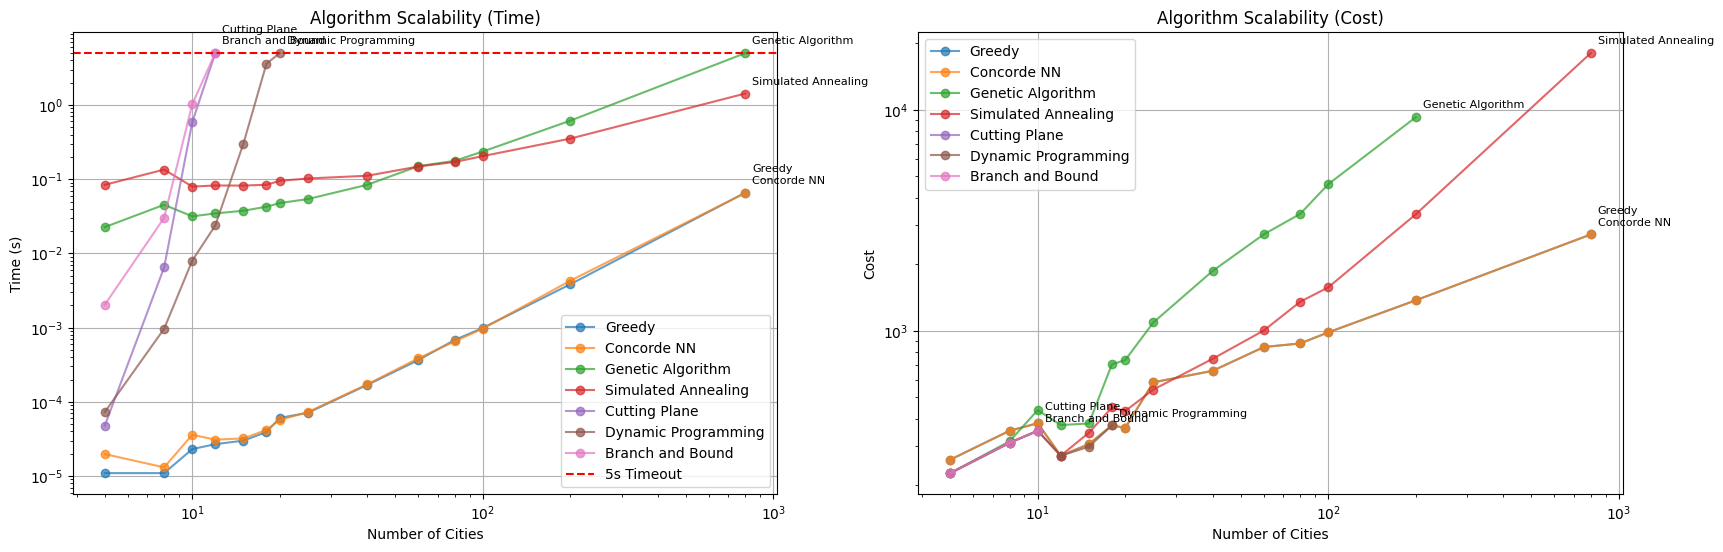


Feasible City Counts (completing in <5s, no skips):
Branch and Bound: up to 10 cities
Dynamic Programming: up to 18 cities
Cutting Plane: up to 10 cities
Simulated Annealing: up to 800 cities
Genetic Algorithm: up to 200 cities
Concorde NN: up to 800 cities
Greedy: up to 800 cities


In [42]:
# Plot scalability
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Time plot
ax = axes[0]
end_points_time = {}
for name in reversed(list(results.keys())):
    ns = [r[0] for r in results[name]]
    times = []
    for r in results[name]:
        if r[3] == "Complete":
            times.append(r[2])
        elif r[3] == "Skipped":
            times.append(None)  # Will show as gap in plot
        else:  # Timeout
            times.append(5.0)
    line = ax.plot(ns, times, marker='o', label=name, alpha=0.7)
    # Collect end points
    valid_indices = [i for i, t in enumerate(times) if t is not None]
    if valid_indices:
        last_idx = valid_indices[-1]
        point = (ns[last_idx], times[last_idx])
        if point not in end_points_time:
            end_points_time[point] = []
        end_points_time[point].append(name)

# Group nearby points for time plot
epsilon = 0.01
grouped_time = {}
for point, names in end_points_time.items():
    found_group = False
    for group_point in grouped_time:
        if abs(point[0] - group_point[0]) < epsilon and abs(point[1] - group_point[1]) < epsilon:
            grouped_time[group_point].extend(names)
            found_group = True
            break
    if not found_group:
        grouped_time[point] = names

# Add labels for time plot
for point, names in grouped_time.items():
    if len(names) == 1:
        ax.annotate(names[0], point, xytext=(5, 5), textcoords='offset points',
                   fontsize=8, ha='left', va='bottom')
    else:
        label = '\n'.join(names)
        ax.annotate(label, point, xytext=(5, 5), textcoords='offset points',
                   fontsize=8, ha='left', va='bottom')

ax.axhline(y=5.0, color='r', linestyle='--', label='5s Timeout')
ax.set_xlabel('Number of Cities')
ax.set_ylabel('Time (s)')
ax.set_title('Algorithm Scalability (Time)')
ax.legend()
ax.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')

# Cost plot
ax = axes[1]
end_points_cost = {}
for name in reversed(list(results.keys())):
    ns = [r[0] for r in results[name]]
    costs = [r[1] if r[3] == "Complete" else None for r in results[name]]
    line = ax.plot(ns, costs, marker='o', label=name, alpha=0.7)
    # Collect end points
    valid_indices = [i for i, c in enumerate(costs) if c is not None]
    if valid_indices:
        last_idx = valid_indices[-1]
        point = (ns[last_idx], costs[last_idx])
        if point not in end_points_cost:
            end_points_cost[point] = []
        end_points_cost[point].append(name)

# Group nearby points for cost plot
grouped_cost = {}
for point, names in end_points_cost.items():
    found_group = False
    for group_point in grouped_cost:
        if abs(point[0] - group_point[0]) < epsilon and abs(point[1] - group_point[1]) < epsilon:
            grouped_cost[group_point].extend(names)
            found_group = True
            break
    if not found_group:
        grouped_cost[point] = names

# Add labels for cost plot
for point, names in grouped_cost.items():
    if len(names) == 1:
        ax.annotate(names[0], point, xytext=(5, 5), textcoords='offset points',
                   fontsize=8, ha='left', va='bottom')
    else:
        label = '\n'.join(names)
        ax.annotate(label, point, xytext=(5, 5), textcoords='offset points',
                   fontsize=8, ha='left', va='bottom')

"""# Cost plot
ax = axes[1]
for name in list(results.keys()):
    ns = [r[0] for r in results[name]]
    costs = [r[1] if r[3] == "Complete" else None for r in results[name]]
    ax.plot(ns, costs, marker='o', label=name)"""




ax.set_xlabel('Number of Cities')
ax.set_ylabel('Cost')
ax.set_title('Algorithm Scalability (Cost)')
ax.legend()
ax.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

# Summary of feasible sizes
print("\nFeasible City Counts (completing in <5s, no skips):")
for name in results:
    feasible = [r[0] for r in results[name] if r[3] == "Complete"]
    max_feasible = max(feasible) if feasible else 0
    print(f"{name}: up to {max_feasible} cities")